# Per-Metro Model v3: Data Preparation

## Approach
- **Training Example**: (Neighborhood, Time Point) pair
- **Features**: Historical patterns, trends, volatility, metro characteristics
- **Target**: Home Price (ZHVI) at that time point
- **Split**: 80% train, 20% test (random, stratified)
- **Validation**: Model must predict prices accurately, especially for 2025 data

## Why This Works
The model learns price patterns from ALL available data (2000-2025). When tested on held-out examples including 2025, we validate it can predict current prices. Future appreciation = predicted future price vs current price.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Load Raw Data

In [2]:
# Load raw Zillow ZHVI data
df_zhvi = pd.read_csv('../data/raw/zillow_zhvi_neighborhoods.csv')

# Identify metadata vs date columns
metadata_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']
date_cols = [col for col in df_zhvi.columns if col not in metadata_cols]

print(f"Total rows: {len(df_zhvi):,}")
print(f"Date columns: {len(date_cols)}")
print(f"Date range: {date_cols[0]} to {date_cols[-1]}")

Total rows: 21,616
Date columns: 310
Date range: 2000-01-31 to 2025-10-31


In [3]:
# Filter to neighborhoods only (not cities, metros, etc.)
df_neighborhoods = df_zhvi[df_zhvi['RegionType'] == 'neighborhood'].copy()
print(f"Neighborhoods: {len(df_neighborhoods):,}")

Neighborhoods: 21,616


## 2. Filter to App Metros

In [4]:
# Define app metros and their cities
APP_METROS = {
    'austin': ['Austin'],
    'dallas': ['Dallas', 'Plano', 'Frisco', 'McKinney', 'Allen', 'Richardson', 'Carrollton', 
               'Lewisville', 'Flower Mound', 'Irving', 'Garland', 'Mesquite', 'Grand Prairie',
               'Rowlett', 'Wylie', 'Rockwall', 'Sachse', 'Murphy', 'The Colony', 'Little Elm',
               'Prosper', 'Celina', 'Fairview'],
    'fort_worth': ['Fort Worth', 'Arlington', 'Keller', 'Southlake', 'Grapevine', 'Colleyville',
                   'Bedford', 'Euless', 'Hurst', 'North Richland Hills', 'Haltom City', 'Watauga',
                   'Saginaw', 'White Settlement', 'Benbrook', 'Crowley', 'Burleson', 'Mansfield',
                   'Weatherford', 'Azle', 'Lake Worth'],
    'houston': ['Houston', 'Sugar Land', 'Missouri City', 'Pearland', 'League City', 'Friendswood',
                'Pasadena', 'Baytown', 'La Porte', 'Deer Park', 'Katy', 'Cypress', 'Spring',
                'The Woodlands', 'Humble', 'Kingwood', 'Atascocita', 'Channelview'],
    'san_antonio': ['San Antonio'],
    'abilene': ['Abilene'],
    'waco': ['Waco'],
    'miami': ['Miami', 'Miami Beach', 'Coral Gables', 'Hialeah', 'Homestead'],
    'fort_lauderdale': ['Fort Lauderdale', 'Hollywood', 'Pompano Beach', 'Deerfield Beach', 
                        'Coral Springs', 'Pembroke Pines', 'Miramar', 'Davie', 'Plantation',
                        'Sunrise', 'Weston', 'Coconut Creek', 'Margate', 'Tamarac'],
    'orlando': ['Orlando', 'Kissimmee', 'Sanford', 'Winter Park', 'Ocoee', 'Apopka'],
    'tampa': ['Tampa', 'St. Petersburg', 'Clearwater', 'Brandon', 'Riverview', 'Valrico'],
    'jacksonville': ['Jacksonville', 'Jacksonville Beach', 'Atlantic Beach', 'Neptune Beach']
}

# Create city-to-metro mapping
city_to_metro = {}
for metro, cities in APP_METROS.items():
    for city in cities:
        city_to_metro[city] = metro

# Filter to app cities and assign metro
all_cities = list(city_to_metro.keys())
df_app = df_neighborhoods[df_neighborhoods['City'].isin(all_cities)].copy()
df_app['metro'] = df_app['City'].map(city_to_metro)

print(f"Neighborhoods in app metros: {len(df_app):,}")
print(f"\nBy metro:")
print(df_app['metro'].value_counts())

Neighborhoods in app metros: 3,311

By metro:
metro
fort_worth         730
dallas             687
houston            526
san_antonio        326
fort_lauderdale    286
tampa              192
jacksonville       186
orlando            149
miami              119
austin              66
abilene             22
waco                22
Name: count, dtype: int64


## 3. Create Training Examples

Each example is a (neighborhood, time_point) pair:
- **Features**: Derived from price history BEFORE the time point
- **Target**: Actual price AT the time point

In [5]:
# Convert date columns to datetime for easier manipulation
date_cols_dt = pd.to_datetime(date_cols)

# We'll sample time points at yearly intervals to keep dataset manageable
# Use January of each year from 2005 to 2025
# (Need at least 5 years of history for meaningful features)
sample_years = list(range(2005, 2026))
sample_dates = [f"{year}-01-31" for year in sample_years]

# Find closest actual date column for each sample date
def find_closest_date_col(target_date, date_cols, date_cols_dt):
    """Find the date column closest to target date."""
    target = pd.to_datetime(target_date)
    diffs = abs(date_cols_dt - target)
    closest_idx = diffs.argmin()
    return date_cols[closest_idx], closest_idx

sample_date_cols = []
for sd in sample_dates:
    col, idx = find_closest_date_col(sd, date_cols, date_cols_dt)
    sample_date_cols.append((sd[:4], col, idx))  # (year, column_name, index)

print("Sample time points:")
for year, col, idx in sample_date_cols:
    print(f"  {year}: {col}")

Sample time points:
  2005: 2005-01-31
  2006: 2006-01-31
  2007: 2007-01-31
  2008: 2008-01-31
  2009: 2009-01-31
  2010: 2010-01-31
  2011: 2011-01-31
  2012: 2012-01-31
  2013: 2013-01-31
  2014: 2014-01-31
  2015: 2015-01-31
  2016: 2016-01-31
  2017: 2017-01-31
  2018: 2018-01-31
  2019: 2019-01-31
  2020: 2020-01-31
  2021: 2021-01-31
  2022: 2022-01-31
  2023: 2023-01-31
  2024: 2024-01-31
  2025: 2025-01-31


In [6]:
def extract_features_for_timepoint(row, date_cols, target_col_idx, metro_medians_at_time):
    """
    Extract features for a neighborhood at a specific time point.
    
    Features are calculated from price history BEFORE target_col_idx.
    Target is the price AT target_col_idx.
    
    Args:
        row: DataFrame row with neighborhood data
        date_cols: List of date column names
        target_col_idx: Index of the target date column
        metro_medians_at_time: Dict of metro median prices at this time point
    
    Returns:
        Dict of features, or None if insufficient data
    """
    # Get price history up to (but not including) target
    history_cols = date_cols[:target_col_idx]
    if len(history_cols) < 24:  # Need at least 2 years of history
        return None
    
    prices = row[history_cols].values.astype(float)
    target_price = row[date_cols[target_col_idx]]
    
    # Skip if target price is missing
    if pd.isna(target_price) or target_price <= 0:
        return None
    
    # Calculate valid prices (non-NaN)
    valid_mask = ~np.isnan(prices)
    valid_prices = prices[valid_mask]
    
    if len(valid_prices) < 24:  # Need at least 2 years of valid data
        return None
    
    features = {}
    
    # === TREND FEATURES ===
    # Most recent price (last valid price before target)
    features['prev_price'] = valid_prices[-1]
    features['log_prev_price'] = np.log(valid_prices[-1])
    
    # CAGRs over various periods (using most recent data)
    n = len(valid_prices)
    
    # 1-year CAGR (12 months)
    if n >= 12:
        features['cagr_1yr'] = ((valid_prices[-1] / valid_prices[-12]) - 1) * 100
    else:
        features['cagr_1yr'] = np.nan
    
    # 3-year CAGR
    if n >= 36:
        features['cagr_3yr'] = (((valid_prices[-1] / valid_prices[-36]) ** (1/3)) - 1) * 100
    else:
        features['cagr_3yr'] = np.nan
    
    # 5-year CAGR
    if n >= 60:
        features['cagr_5yr'] = (((valid_prices[-1] / valid_prices[-60]) ** (1/5)) - 1) * 100
    else:
        features['cagr_5yr'] = np.nan
    
    # Full history CAGR
    years_of_data = n / 12
    if years_of_data > 0:
        features['cagr_full'] = (((valid_prices[-1] / valid_prices[0]) ** (1/years_of_data)) - 1) * 100
    else:
        features['cagr_full'] = np.nan
    
    # Trend acceleration (recent vs long-term)
    if not np.isnan(features.get('cagr_3yr', np.nan)) and not np.isnan(features.get('cagr_full', np.nan)):
        features['trend_acceleration'] = features['cagr_3yr'] - features['cagr_full']
    else:
        features['trend_acceleration'] = np.nan
    
    # Momentum (recent month-over-month)
    if n >= 3:
        features['momentum_3m'] = ((valid_prices[-1] / valid_prices[-3]) - 1) * 100
    else:
        features['momentum_3m'] = np.nan
    
    # === VOLATILITY FEATURES ===
    # Monthly returns
    returns = np.diff(valid_prices) / valid_prices[:-1] * 100
    
    features['volatility'] = np.std(returns) if len(returns) > 0 else np.nan
    
    negative_returns = returns[returns < 0]
    features['downside_volatility'] = np.std(negative_returns) if len(negative_returns) > 0 else 0
    
    # Max drawdown
    cummax = np.maximum.accumulate(valid_prices)
    drawdowns = (cummax - valid_prices) / cummax * 100
    features['max_drawdown'] = np.max(drawdowns) if len(drawdowns) > 0 else 0
    
    # === CYCLE FEATURES ===
    # Distance from historical peak
    peak_price = np.max(valid_prices)
    features['distance_from_peak'] = ((valid_prices[-1] / peak_price) - 1) * 100
    
    # Months since peak
    peak_idx = np.argmax(valid_prices)
    features['months_since_peak'] = len(valid_prices) - peak_idx - 1
    
    # === RELATIVE FEATURES ===
    metro = row['metro']
    metro_median = metro_medians_at_time.get(metro, np.nan)
    if not np.isnan(metro_median) and metro_median > 0:
        features['price_to_metro_median'] = valid_prices[-1] / metro_median
    else:
        features['price_to_metro_median'] = np.nan
    
    # === DATA QUALITY ===
    features['data_coverage'] = valid_mask.sum() / len(prices) * 100
    features['history_months'] = n
    
    return features

In [7]:
def compute_metro_medians_at_timepoint(df, date_col):
    """Compute median price for each metro at a specific time point."""
    medians = {}
    for metro in df['metro'].unique():
        metro_prices = df[df['metro'] == metro][date_col].dropna()
        if len(metro_prices) > 0:
            medians[metro] = metro_prices.median()
    return medians

In [8]:
# Create all training examples
print("Creating training examples...")
print("This will take a few minutes.\n")

all_examples = []

for year, target_col, target_idx in sample_date_cols:
    print(f"Processing {year} (target column: {target_col})...")
    
    # Compute metro medians at this time point
    # Use the column just before target for computing medians
    if target_idx > 0:
        median_col = date_cols[target_idx - 1]
    else:
        median_col = date_cols[0]
    metro_medians = compute_metro_medians_at_timepoint(df_app, median_col)
    
    count = 0
    for idx, row in df_app.iterrows():
        features = extract_features_for_timepoint(row, date_cols, target_idx, metro_medians)
        
        if features is None:
            continue
        
        # Add metadata
        features['neighborhood_id'] = row['RegionID']
        features['neighborhood_name'] = row['RegionName']
        features['city'] = row['City']
        features['metro'] = row['metro']
        features['year'] = int(year)
        features['target_date'] = target_col
        
        # TARGET: actual price at this time point
        features['target_price'] = row[target_col]
        features['log_target_price'] = np.log(row[target_col])
        
        all_examples.append(features)
        count += 1
    
    print(f"  Created {count:,} examples")

df_examples = pd.DataFrame(all_examples)
print(f"\nTotal examples created: {len(df_examples):,}")

Creating training examples...
This will take a few minutes.

Processing 2005 (target column: 2005-01-31)...
  Created 1,770 examples
Processing 2006 (target column: 2006-01-31)...
  Created 1,821 examples
Processing 2007 (target column: 2007-01-31)...
  Created 1,933 examples
Processing 2008 (target column: 2008-01-31)...
  Created 1,991 examples
Processing 2009 (target column: 2009-01-31)...
  Created 2,053 examples
Processing 2010 (target column: 2010-01-31)...
  Created 2,124 examples
Processing 2011 (target column: 2011-01-31)...
  Created 2,252 examples
Processing 2012 (target column: 2012-01-31)...
  Created 2,330 examples
Processing 2013 (target column: 2013-01-31)...
  Created 2,378 examples
Processing 2014 (target column: 2014-01-31)...
  Created 2,444 examples
Processing 2015 (target column: 2015-01-31)...
  Created 2,501 examples
Processing 2016 (target column: 2016-01-31)...
  Created 2,517 examples
Processing 2017 (target column: 2017-01-31)...
  Created 2,543 examples
Pro

In [9]:
# Examine the dataset
print("Dataset shape:", df_examples.shape)
print("\nColumns:")
print(df_examples.columns.tolist())
print("\nExamples by year:")
print(df_examples['year'].value_counts().sort_index())

Dataset shape: (50031, 24)

Columns:
['prev_price', 'log_prev_price', 'cagr_1yr', 'cagr_3yr', 'cagr_5yr', 'cagr_full', 'trend_acceleration', 'momentum_3m', 'volatility', 'downside_volatility', 'max_drawdown', 'distance_from_peak', 'months_since_peak', 'price_to_metro_median', 'data_coverage', 'history_months', 'neighborhood_id', 'neighborhood_name', 'city', 'metro', 'year', 'target_date', 'target_price', 'log_target_price']

Examples by year:
year
2005    1770
2006    1821
2007    1933
2008    1991
2009    2053
2010    2124
2011    2252
2012    2330
2013    2378
2014    2444
2015    2501
2016    2517
2017    2543
2018    2587
2019    2624
2020    2634
2021    2669
2022    2690
2023    2718
2024    2725
2025    2727
Name: count, dtype: int64


In [10]:
# Check for missing values
print("Missing values per column:")
missing = df_examples.isnull().sum()
print(missing[missing > 0])

Missing values per column:
cagr_3yr              1016
cagr_5yr              3174
trend_acceleration    1016
dtype: int64


Target price statistics:
count    5.003100e+04
mean     2.886997e+05
std      3.097054e+05
min      1.824279e+04
25%      1.398161e+05
50%      2.226194e+05
75%      3.459479e+05
max      1.001764e+07
Name: target_price, dtype: float64


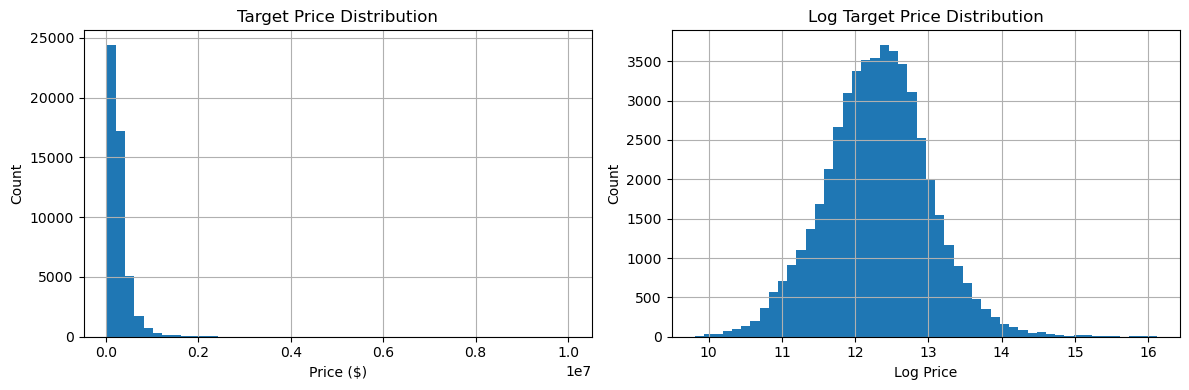

In [11]:
# Target distribution
print("Target price statistics:")
print(df_examples['target_price'].describe())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
df_examples['target_price'].hist(bins=50, ax=ax)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Count')
ax.set_title('Target Price Distribution')

ax = axes[1]
df_examples['log_target_price'].hist(bins=50, ax=ax)
ax.set_xlabel('Log Price')
ax.set_ylabel('Count')
ax.set_title('Log Target Price Distribution')

plt.tight_layout()
plt.show()

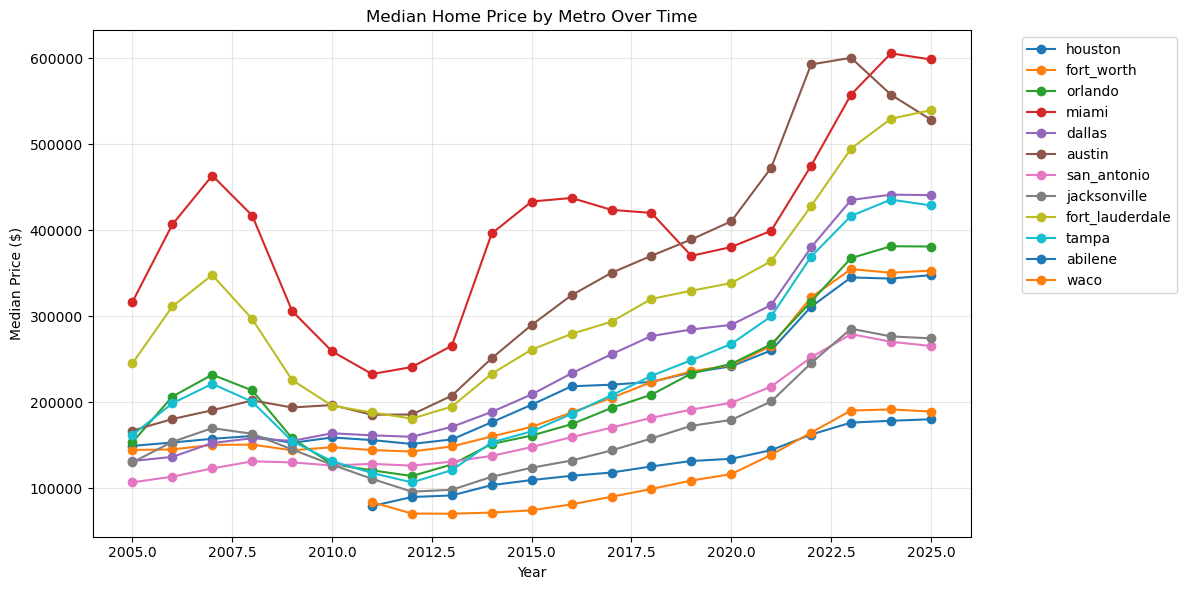

In [12]:
# Price trends over time by metro
fig, ax = plt.subplots(figsize=(12, 6))

for metro in df_examples['metro'].unique():
    metro_data = df_examples[df_examples['metro'] == metro]
    yearly_median = metro_data.groupby('year')['target_price'].median()
    ax.plot(yearly_median.index, yearly_median.values, marker='o', label=metro)

ax.set_xlabel('Year')
ax.set_ylabel('Median Price ($)')
ax.set_title('Median Home Price by Metro Over Time')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Train/Test Split

80/20 random split, stratified by metro and year bucket to ensure coverage.

In [13]:
from sklearn.model_selection import train_test_split

# Create stratification key (metro + year bucket)
def get_year_bucket(year):
    if year < 2010:
        return 'pre-2010'
    elif year < 2015:
        return '2010-2014'
    elif year < 2020:
        return '2015-2019'
    else:
        return '2020+'

df_examples['year_bucket'] = df_examples['year'].apply(get_year_bucket)
df_examples['stratify_key'] = df_examples['metro'] + '_' + df_examples['year_bucket']

print("Stratification groups:")
print(df_examples['stratify_key'].value_counts())

Stratification groups:
stratify_key
dallas_2020+                 3855
fort_worth_2020+             3573
dallas_2015-2019             3000
fort_worth_2015-2019         2820
dallas_2010-2014             2568
fort_worth_2010-2014         2450
fort_worth_pre-2010          1975
san_antonio_2020+            1948
dallas_pre-2010              1782
san_antonio_2015-2019        1605
san_antonio_2010-2014        1567
fort_lauderdale_2020+        1558
houston_2020+                1470
san_antonio_pre-2010         1398
fort_lauderdale_2015-2019    1249
fort_lauderdale_2010-2014    1152
houston_2015-2019            1134
jacksonville_2020+           1113
houston_2010-2014            1057
fort_lauderdale_pre-2010     1050
houston_pre-2010              953
jacksonville_2015-2019        904
orlando_2020+                 851
jacksonville_2010-2014        841
jacksonville_pre-2010         825
tampa_2020+                   817
tampa_2015-2019               657
orlando_2015-2019             656
tampa_2010-2

In [14]:
# Perform train/test split
train_df, test_df = train_test_split(
    df_examples,
    test_size=0.20,
    stratify=df_examples['stratify_key'],
    random_state=42
)

print(f"Train set: {len(train_df):,} examples ({len(train_df)/len(df_examples)*100:.1f}%)")
print(f"Test set: {len(test_df):,} examples ({len(test_df)/len(df_examples)*100:.1f}%)")

Train set: 40,024 examples (80.0%)
Test set: 10,007 examples (20.0%)


In [15]:
# Verify test set includes recent examples
print("\nTest set by year:")
print(test_df['year'].value_counts().sort_index())

print("\nTest set examples from 2025:")
print(f"  Count: {len(test_df[test_df['year'] == 2025])}")
print(f"  Metros: {test_df[test_df['year'] == 2025]['metro'].unique().tolist()}")


Test set by year:
year
2005    365
2006    359
2007    398
2008    399
2009    394
2010    415
2011    427
2012    495
2013    468
2014    500
2015    500
2016    522
2017    473
2018    524
2019    535
2020    503
2021    571
2022    493
2023    549
2024    579
2025    538
Name: count, dtype: int64

Test set examples from 2025:
  Count: 538
  Metros: ['dallas', 'fort_worth', 'orlando', 'san_antonio', 'austin', 'jacksonville', 'houston', 'tampa', 'abilene', 'fort_lauderdale', 'miami', 'waco']


## 5. Save Prepared Data

In [16]:
# Define feature columns (exclude metadata and target)
metadata_cols = ['neighborhood_id', 'neighborhood_name', 'city', 'metro', 'year', 
                 'target_date', 'year_bucket', 'stratify_key']
target_cols = ['target_price', 'log_target_price']

feature_cols = [col for col in df_examples.columns if col not in metadata_cols + target_cols]

print(f"Feature columns ({len(feature_cols)}):")
print(feature_cols)

Feature columns (16):
['prev_price', 'log_prev_price', 'cagr_1yr', 'cagr_3yr', 'cagr_5yr', 'cagr_full', 'trend_acceleration', 'momentum_3m', 'volatility', 'downside_volatility', 'max_drawdown', 'distance_from_peak', 'months_since_peak', 'price_to_metro_median', 'data_coverage', 'history_months']


In [17]:
# Save everything for the training notebook
prepared_data = {
    'train_df': train_df,
    'test_df': test_df,
    'feature_cols': feature_cols,
    'target_col': 'target_price',  # or 'log_target_price' for log-space modeling
    'metadata_cols': metadata_cols,
    'df_app': df_app,  # Original filtered data for reference
    'date_cols': date_cols  # For future predictions
}

output_path = Path('../data/processed/ml_data_v3.pkl')
with open(output_path, 'wb') as f:
    pickle.dump(prepared_data, f)

print(f"Saved prepared data to {output_path}")
print(f"\nContents:")
print(f"  train_df: {len(train_df):,} examples")
print(f"  test_df: {len(test_df):,} examples")
print(f"  feature_cols: {len(feature_cols)} features")

Saved prepared data to ../data/processed/ml_data_v3.pkl

Contents:
  train_df: 40,024 examples
  test_df: 10,007 examples
  feature_cols: 16 features


## Summary

**Data prepared for training:**
- Training examples: (neighborhood, time_point) pairs from 2005-2025
- Features: Historical price patterns, trends, volatility, relative metrics
- Target: Actual home price at time point
- Split: 80% train, 20% test (stratified by metro and time period)

**Next step:** Run `04_model_training_v3.ipynb` to train per-metro models.